In [1]:
import numpy as np

row = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])  # Example row indices

grad_row = np.stack([row * 2, row * 2 + 1], axis=1).flatten()
print(grad_row)


[0 1 0 1 0 1 2 3 2 3 2 3 4 5 4 5 4 5]


In [6]:
import numpy as np
from pcdiff import knn_graph, estimate_basis, build_grad_div, laplacian, coords_projected, weighted_least_squares, gaussian_weights
import numpy as np
import numpy.linalg as LA
from scipy.sparse import coo_matrix

regularizer=1e-8
shape_regularizer=None

data = np.loadtxt('C:/Users/aagaa/Documents/GitHub/R-D/Code/Leihui Code/src/data/bunny.xyz')
pos = data[:, 0:3]
# Random point cloud
#pos = np.random.rand(1000, 3)

Cloud_size = np.size(pos,0)

# Generate kNN graph
edge_index = knn_graph(pos, 20)
# Estimate normals and local frames
basis = estimate_basis(pos, edge_index)

row, col = edge_index
k = (row == 0).sum()

# Get coordinates in tangent plane by projecting along the normal of the plane
coords = coords_projected(pos, *basis, edge_index)

# Compute weights based on distance in euclidean space
dist = LA.norm(pos[col] - pos[row], axis=1)
weights = gaussian_weights(dist, k, 1)

# Get weighted least squares result
# wls multiplied with a function f at k neighbors will give the coefficients c0-c5
# for the surface f(x, y) = [x, y, c0 + c1*x + c2*y + c3*x**2 + c4*xy + c5*y**2]
# defined on a neighborhood of each point.
if shape_regularizer is None:
    wls = weighted_least_squares(coords, weights, k, regularizer)
else:
    wls, wls_shape = weighted_least_squares(coords, weights, k, regularizer, shape_regularizer)

# Format as sparse matrix

# The gradient of f at (0, 0) will be
# df/dx|(0, 0) = [1, 0, c1 + 2*c3*0 + c4*0] = [1, 0, c1]
# df/dy|(0, 0) = [0, 1, c2 + c4*0 + 2*c5*0] = [0, 1, c2]
# Hence, we can use the row in wls that outputs c1 and c2 for the gradient
# in x direction and y direction, respectively
grad_row = np.stack([row * 2, row * 2 + 1], axis=1).flatten()
grad_col = np.stack([col]*2, axis=1).flatten()
grad_values = np.stack([wls[:, 1], wls[:, 2]], axis=1).flatten()

# Create gradient matrix
grad = coo_matrix((grad_values, (grad_row, grad_col)), shape=(pos.shape[0] * 2, pos.shape[0]))

print(wls.shape)
print(grad.shape)
print(pos.shape)
print(grad_row[0:40])
print(grad_col.shape)
print(grad_values.shape)
print(np.sum(grad.row==0))

(718940, 6)
(71894, 35947)
(35947, 3)
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1]
(1437880,)
(1437880,)
20


In [9]:
from pcdiff import knn_graph, estimate_basis, build_grad_div




def calculate_gradients(pointcloud, k_neighbors):
    #TODO: Find out if this is only grad_x or just the gradient found here, maybe need more info for complete gradient
    edge_index = knn_graph(pointcloud, k_neighbors)
    normal, x_basis, y_basis = estimate_basis(pointcloud, edge_index)
    row, col = edge_index
    k = (row == 0).sum()

    # Get coordinates in tangent plane by projecting along the normal of the plane
    coords = coords_projected(pos, *basis, edge_index)

    # Compute weights based on distance in euclidean space
    dist = LA.norm(pos[col] - pos[row], axis=1)
    weights = gaussian_weights(dist, k, 1)

    # Get weighted least squares result
    # wls multiplied with a function f at k neighbors will give the coefficients c0-c5
    # for the surface f(x, y) = [x, y, c0 + c1*x + c2*y + c3*x**2 + c4*xy + c5*y**2]
    # defined on a neighborhood of each point.
    if shape_regularizer is None:
        wls = weighted_least_squares(coords, weights, k, regularizer)
    else:
        wls, wls_shape = weighted_least_squares(coords, weights, k, regularizer, shape_regularizer)
    
    gradients = wls[::20,1:3]    
    return gradients 


In [10]:
calculate_gradients(pos, 20)

array([[  3.50776946,  -1.14131284],
       [ -2.29210178,   1.41623772],
       [ -5.53423966,   4.80631342],
       ...,
       [-77.71204982, -21.36010264],
       [ 44.63317144, -15.24749962],
       [  9.5745682 ,   3.04100186]])

In [5]:

# Generate a base sequence from 1 to 300 (300 rows)
base = np.arange(1, 301).reshape(-1, 1)  # Shape: (300, 1)

# Create the 300x6 matrix with shifted values in columns
arr = base + np.arange(6)  # Broadcasting shifts each column

print(arr)

print(arr[::20,1:3])

[[  1   2   3   4   5   6]
 [  2   3   4   5   6   7]
 [  3   4   5   6   7   8]
 ...
 [298 299 300 301 302 303]
 [299 300 301 302 303 304]
 [300 301 302 303 304 305]]
[[  2   3]
 [ 22  23]
 [ 42  43]
 [ 62  63]
 [ 82  83]
 [102 103]
 [122 123]
 [142 143]
 [162 163]
 [182 183]
 [202 203]
 [222 223]
 [242 243]
 [262 263]
 [282 283]]


In [16]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random 3D points
np.random.seed(42)
N = 20  # Number of points
x = np.random.uniform(-5, 5, N)
y = np.random.uniform(-5, 5, N)

# Define an underlying quadratic surface with noise
z_true = 1 + 2*x + 3*y + 0.5*x**2 + 0.2*x*y + 0.1*y**2  # True surface
z_noisy = z_true + np.random.normal(0, 1, size=N)  # Add noise


In [44]:
file_path = "Data/Training_data/CombinedDataset.txt"
rawpoints = np.loadtxt(file_path, usecols=(0, 1, 2))  # Load only the first three columns (x, y, z)
print(f"Loaded {rawpoints.shape[0]} points from {file_path}")
x = rawpoints[20:40,0]
y = rawpoints[20:40,1]
z = rawpoints[20:40,2]
print(x)

Loaded 2000 points from Data/Training_data/CombinedDataset.txt
[ 0.       -0.007964  0.008069  0.000622 -0.000595 -0.007385  0.008648
 -0.008561  0.007413 -0.015832  0.016205 -0.016495  0.015494 -0.015292
  0.016742  0.001165 -0.0237    0.024223 -0.006836  0.009209]


In [ ]:
# Construct the design matrix A
%timeit
A = np.column_stack([
    np.ones(N),    # Constant term (a0)
    x,             # Linear in x (a1)
    y,             # Linear in y (a2)
    x**2,          # Quadratic in x (a3)
    x*y,           # Interaction term (a4)
    y**2,          # Quadratic in y (a5)
])


# Solve the least squares problem using scipy.linalg.lstsq

coeffs, _, _, _ = scipy.linalg.lstsq(A, z)


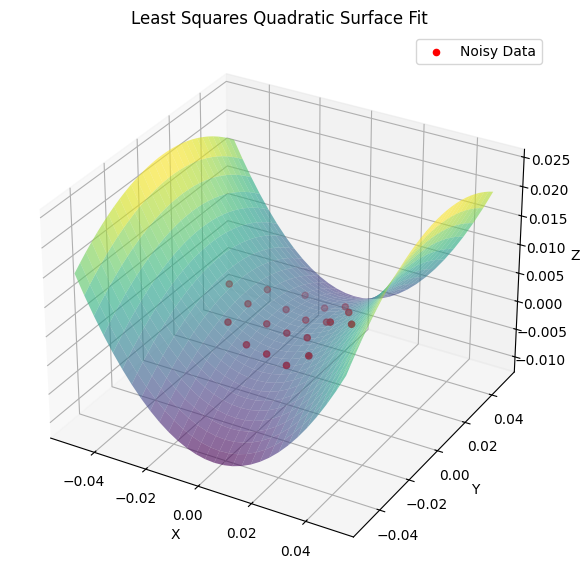

In [57]:
# Generate a smooth grid for visualization
x_grid = np.linspace(-0.05, 0.05, 30)
y_grid = np.linspace(-0.05, 0.05, 30)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the fitted Z values using the solved coefficients
Z_fit = (coeffs[0] + coeffs[1] * X + coeffs[2] * Y +
         coeffs[3] * X**2 + coeffs[4] * X * Y + coeffs[5] * Y**2)

# Plot original points and fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the noisy points
ax.scatter(x, y, z, color='red', label='Noisy Data')

# Plot the fitted surface
ax.plot_surface(X, Y, Z_fit, cmap='viridis', alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Least Squares Quadratic Surface Fit')
ax.legend()
plt.show()


In [61]:
def compute_gradient(x, y, coeffs):
    df_dx = (coeffs[1] + 2 * coeffs[3] * x + coeffs[4] * y)
    df_dy = (coeffs[2] + coeffs[4] * x + 2 * coeffs[5] * y)
    return df_dx, df_dy

# Example: Compute gradients at all original noisy points
%timeit gradients = np.array([compute_gradient(x[i], y[i], coeffs) for i in range(len(x))])

# Print gradients at first 5 points
print("Gradients (dx, dy):\n", gradients)

40.8 μs ± 2.13 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Gradients (dx, dy):
 [[-0.00372293  0.05069582]
 [-0.15348631  0.04316675]
 [ 0.14801582  0.05831623]
 [ 0.01542122 -0.0199759 ]
 [-0.02275053  0.1251361 ]
 [-0.13497176 -0.02925861]
 [ 0.16656926 -0.01448122]
 [-0.17257836  0.11786195]
 [ 0.12760264  0.13498063]
 [-0.3010378   0.03183773]
 [ 0.30190213  0.05750679]
 [-0.32111556  0.10402655]
 [ 0.28022595  0.13630764]
 [-0.28324068 -0.04077719]
 [ 0.31941196 -0.01290193]
 [ 0.03327039 -0.09254621]
 [-0.44858099  0.02042942]
 [ 0.45289883  0.06300247]
 [-0.11699618 -0.10195319]
 [ 0.18475368 -0.08700345]]


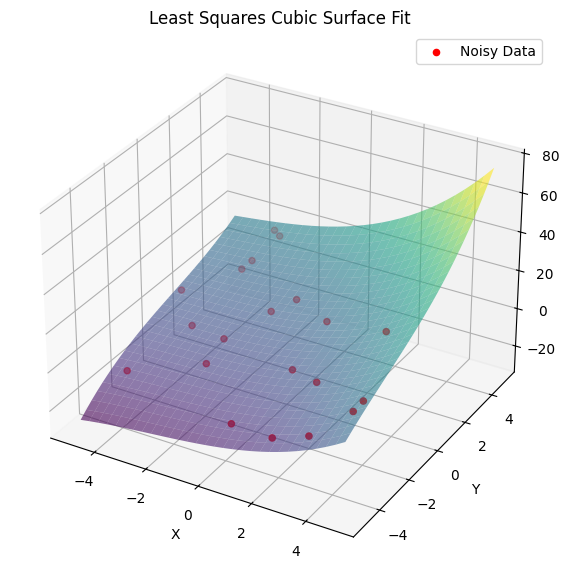

In [5]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random 3D points
np.random.seed(42)
N = 20  # Number of points
x = np.random.uniform(-5, 5, N)
y = np.random.uniform(-5, 5, N)

# Define an underlying cubic surface with noise
z_true = (1 + 2*x + 3*y + 0.5*x**2 + 0.2*x*y + 0.1*y**2 +
          0.05*x**3 + 0.03*x**2*y + 0.02*x*y**2 + 0.04*y**3)

z_noisy = z_true + np.random.normal(0, 1, size=N)  # Add noise

# Construct the updated design matrix A with cubic terms
A = np.column_stack([
    np.ones(N),   # Constant term (a0)
    x,            # Linear in x (a1)
    y,            # Linear in y (a2)
    x**2,         # Quadratic in x (a3)
    x*y,          # Interaction term (a4)
    y**2,         # Quadratic in y (a5)
    x**3,         # Cubic in x (a6)
    x**2*y,       # Mixed x^2y term (a7)
    x*y**2,       # Mixed xy^2 term (a8)
    y**3          # Cubic in y (a9)
])

# Solve the least squares problem
coeffs, _, _, _ = scipy.linalg.lstsq(A, z_noisy)

# Generate a smooth grid for visualization
x_grid = np.linspace(-5, 5, 30)
y_grid = np.linspace(-5, 5, 30)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the fitted Z values using the solved coefficients
Z_fit = (coeffs[0] + coeffs[1] * X + coeffs[2] * Y +
         coeffs[3] * X**2 + coeffs[4] * X * Y + coeffs[5] * Y**2 +
         coeffs[6] * X**3 + coeffs[7] * X**2 * Y + coeffs[8] * X * Y**2 + coeffs[9] * Y**3)

# Plot the original noisy points and fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot noisy data points
ax.scatter(x, y, z_noisy, color='red', label='Noisy Data')

# Plot the fitted cubic surface
ax.plot_surface(X, Y, Z_fit, cmap='viridis', alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Least Squares Cubic Surface Fit')
ax.legend()
plt.show()


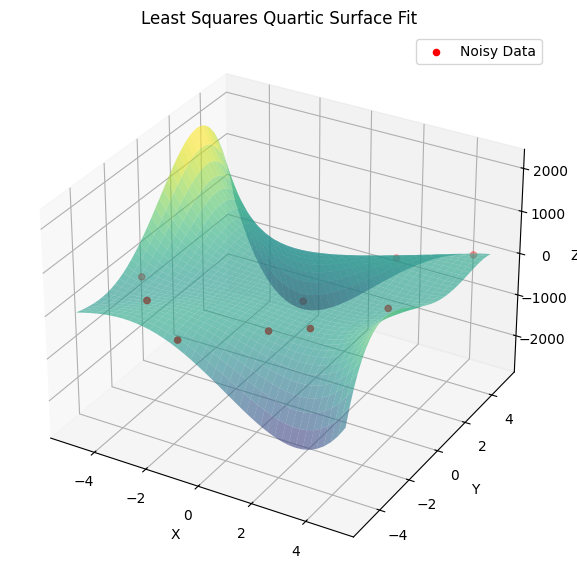

In [8]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random 3D points
np.random.seed(42)
N = 10  # Number of points (increased to avoid overfitting)
x = np.random.uniform(-5, 5, N)
y = np.random.uniform(-5, 5, N)

# Define an underlying quartic surface with noise
z_true = (1 + 2*x + 3*y + 0.5*x**2 + 0.2*x*y + 0.1*y**2 +
          0.05*x**3 + 0.03*x**2*y + 0.02*x*y**2 + 0.04*y**3 +
          0.01*x**4 + 0.007*x**3*y + 0.005*x**2*y**2 + 0.003*x*y**3 + 0.002*y**4)

z_noisy = z_true + np.random.normal(0, 1, size=N)  # Add noise

# Construct the updated design matrix A with quartic terms
A = np.column_stack([
    np.ones(N),    # Constant term (a0)
    x,             # Linear in x (a1)
    y,             # Linear in y (a2)
    x**2,          # Quadratic in x (a3)
    x*y,           # Interaction term (a4)
    y**2,          # Quadratic in y (a5)
    x**3,          # Cubic in x (a6)
    x**2*y,        # Mixed x^2y term (a7)
    x*y**2,        # Mixed xy^2 term (a8)
    y**3,          # Cubic in y (a9)
    x**4,          # Quartic in x (a10)
    x**3*y,        # Mixed x^3y term (a11)
    x**2*y**2,     # Mixed x^2y^2 term (a12)
    x*y**3,        # Mixed xy^3 term (a13)
    y**4           # Quartic in y (a14)
])

# Solve the least squares problem
coeffs, _, _, _ = scipy.linalg.lstsq(A, z_noisy)

# Generate a smooth grid for visualization
x_grid = np.linspace(-5, 5, 40)
y_grid = np.linspace(-5, 5, 40)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the fitted Z values using the solved coefficients
Z_fit = (coeffs[0] + coeffs[1] * X + coeffs[2] * Y +
         coeffs[3] * X**2 + coeffs[4] * X * Y + coeffs[5] * Y**2 +
         coeffs[6] * X**3 + coeffs[7] * X**2 * Y + coeffs[8] * X * Y**2 + coeffs[9] * Y**3 +
         coeffs[10] * X**4 + coeffs[11] * X**3 * Y + coeffs[12] * X**2 * Y**2 +
         coeffs[13] * X * Y**3 + coeffs[14] * Y**4)

# Plot the original noisy points and fitted surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot noisy data points
ax.scatter(x, y, z_noisy, color='red', label='Noisy Data')

# Plot the fitted quartic surface
ax.plot_surface(X, Y, Z_fit, cmap='viridis', alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Least Squares Quartic Surface Fit')
ax.legend()
plt.show()
